# Exploratory Data Analysis of the Merged COVID-19 Dataset

# Table of Contents

1. [Introduction](#introduction)
2. [Data Preview](#data-preview)
3. [Correlation Analysis](#correlation-analysis)
4. [Exploring COVID-19 Case Trends](#exploring-covid-19-case-trends)
5. [Outlier and Data Quality Investigation](#outlier-and-data-quality-investigation)
6. [Cumulative Case Trends](#cumulative-case-trends)
7. [Data Consistency Checks](#data-consistency-checks)
8. [Summary and Next Steps](#summary-and-next-steps)

# <a name="introduction"></a>Introduction

Welcome to the Exploratory Data Analysis (EDA) of the merged COVID-19 dataset for Indian states. In this notebook, we will explore the data, visualize trends, check for correlations, and investigate data quality issues to better understand the dataset and prepare it for modeling.


# <a name="data-preview"></a>Data Preview

Let's start by loading the merged dataset and previewing its structure. This helps us understand what columns are available and inspect a random row for a quick sense-check.


In [2]:
import pandas as pd

# Read the merged CSV file from the processed folder
df = pd.read_csv("../Data/Processed/merged_data.csv")

# Display a row from the DataFrame
print(df.sample(1))

# Display the columns of the DataFrame
print(df.columns)

       state       dates  cum_positive_cases  cum_positivity_rate  \
8590  Kerala  2020-07-23             16111.0             2.631373   

      daily_positive_cases  cum_recovered  daily_recovered  cum_deceased  \
8590                1078.0         6598.0            432.0          51.0   

      daily_deceased  daily_positivity_rate  ...  district_hospitals  \
8590             5.0               4.619472  ...                53.0   

      public_health_facilities  public_beds  rural_hospitals  rural_beds  \
8590                    1297.0      39511.0            981.0     16865.0   

      urban_hospitals  urban_beds  Collection Site  Government Laboratory  \
8590            299.0     21139.0                0                     10   

      Private Laboratory  
8590                   2  

[1 rows x 43 columns]
Index(['state', 'dates', 'cum_positive_cases', 'cum_positivity_rate',
       'daily_positive_cases', 'cum_recovered', 'daily_recovered',
       'cum_deceased', 'daily_deceased', 

# <a name="correlation-analysis"></a>Correlation Analysis

Next, we examine the relationships between numerical features using a correlation matrix. This helps us identify highly correlated variables, which can inform feature selection and highlight potential multicollinearity issues.


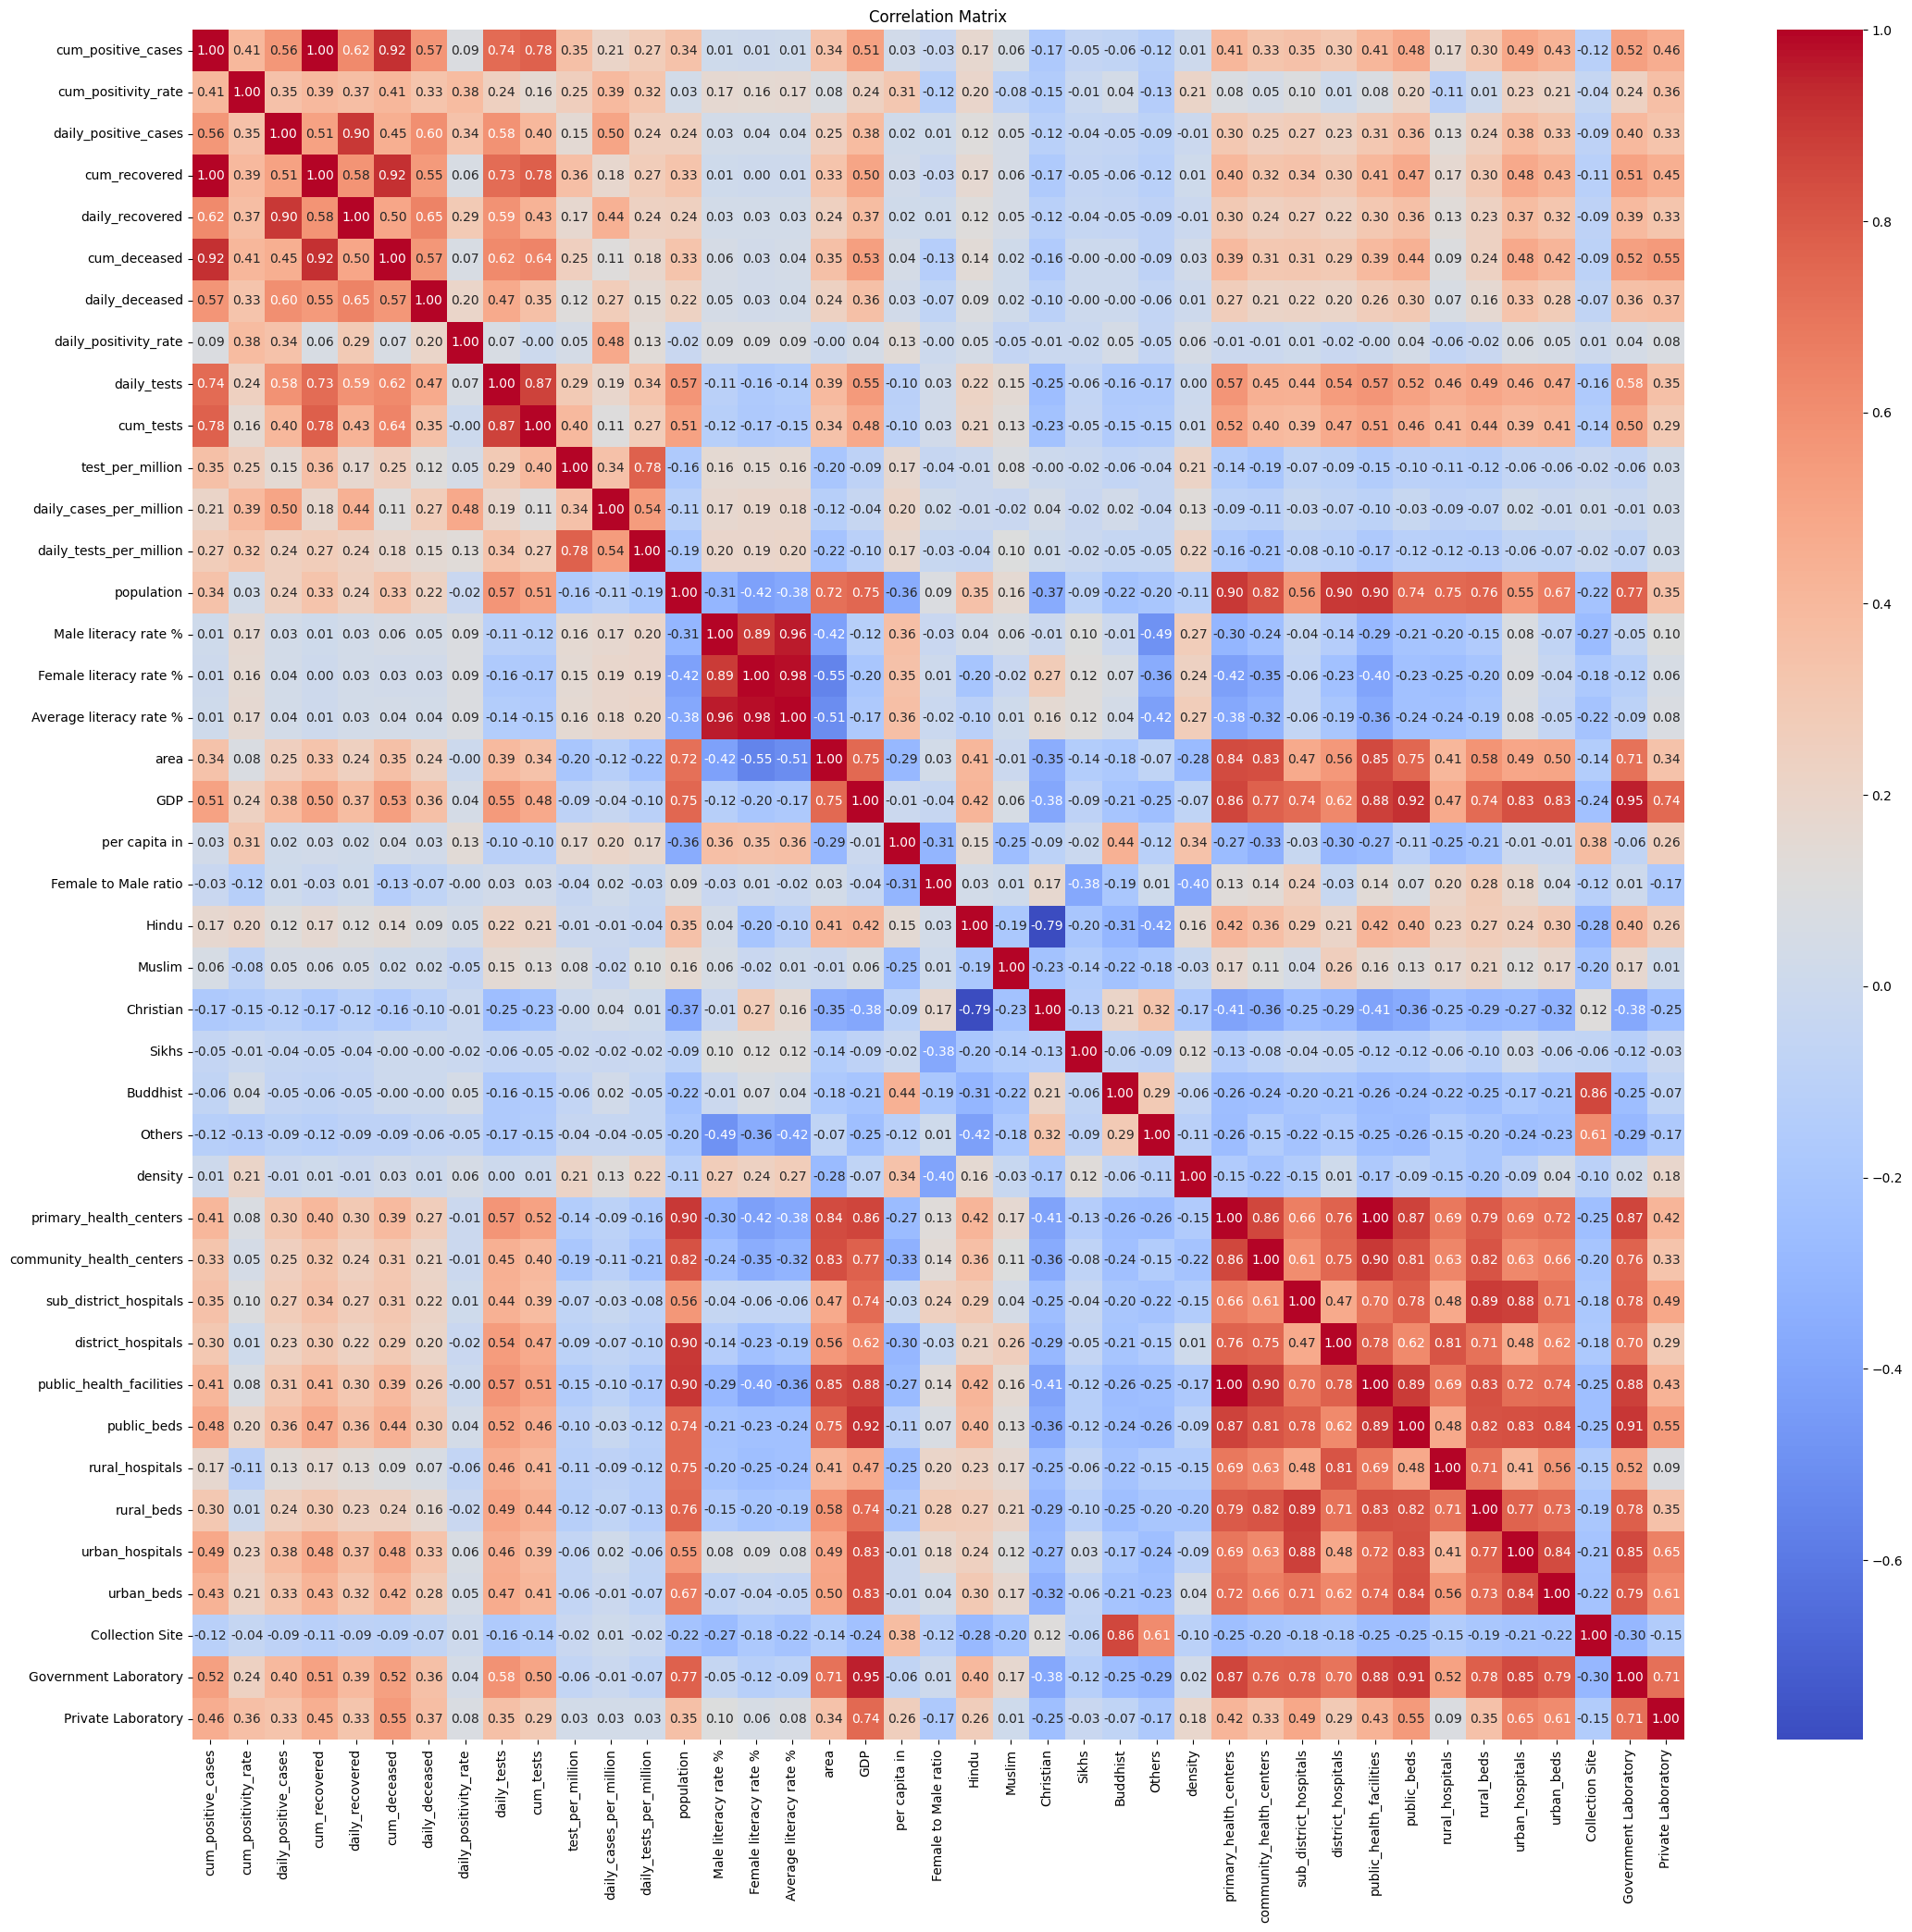

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(26, 24))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

> **Note:**  
> The following columns were removed from the analysis because they interfered with the main research questions or were highly correlated:
>
> ```
> [
>     "cum_positivity_rate", "daily_positive_cases", "cum_recovered", "daily_cases_per_million",
>     "daily_recovered", "cum_deceased", "daily_deceased", "daily_positivity_rate"
> ]
> ```
>
> Removing these columns helps reduce redundancy and potential multicollinearity in the dataset.

# <a name="exploring-covid-19-case-trends"></a>Exploring COVID-19 Case Trends

We now visualize the daily positive COVID-19 cases for each state over time. This allows us to observe the temporal dynamics of the pandemic across different regions and identify peaks, trends, and anomalies.


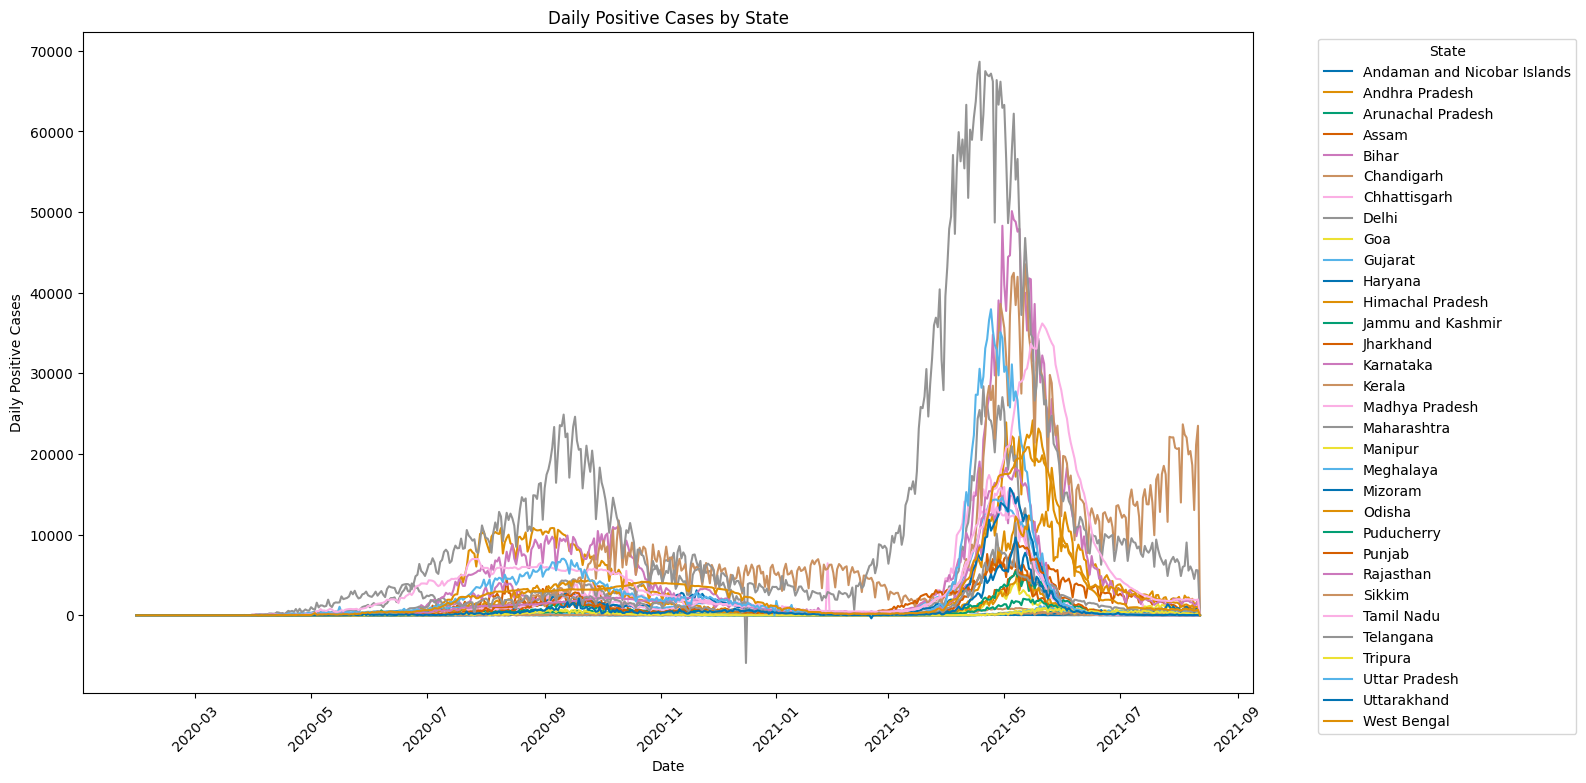

In [4]:
# Ensure 'dates' is datetime
df['dates'] = pd.to_datetime(df['dates'])

plt.figure(figsize=(16, 8))
palette = sns.color_palette("colorblind", n_colors=len(df['state'].unique()))

for i, state in enumerate(df['state'].unique()):
    state_data = df[df['state'] == state]
    plt.plot(state_data['dates'], state_data['daily_positive_cases'], label=state, color=palette[i])

plt.title('Daily Positive Cases by State')
plt.xlabel('Date')
plt.ylabel('Daily Positive Cases')
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

After plotting, we observed some negative values in the daily positive cases, which are not possible in reality. Below, we identify and display these anomalies to better understand their context and plan for appropriate data cleaning.

Additionally, Maharashtra appears as a significant outlier in the data. To simplify the analysis and cleaning process, we will remove Maharashtra from the dataset.

In [5]:
# print the state and date where 'daily_positive_cases' is negative
negative_cases = df[df['daily_positive_cases'] < 0][['state', 'dates', 'daily_positive_cases']]
if not negative_cases.empty:
    print("Negative daily positive cases found:")
    print(negative_cases)

Negative daily positive cases found:
             state      dates  daily_positive_cases
9858   Maharashtra 2020-12-16               -5914.0
10798    Meghalaya 2020-06-17                  -1.0
13009       Punjab 2020-05-15                  -3.0
14187       Sikkim 2020-07-10                 -13.0
15816      Tripura 2020-05-17                  -2.0
17217  Uttarakhand 2021-02-20                -374.0


This presents a challenge for modeling.  
If we train a regression model using lagged features, these sudden drops in cumulative positive cases can disrupt the learning process.  
A better approach is to identify negative daily values and replace them with the mean of the two days before and two days after (excluding the negative value itself).  
After correcting these anomalies, we should also adjust the cumulative positive cases to ensure consistency in the time series.

# <a name="cumulative-case-trends"></a>Cumulative Case Trends

To further understand the progression of the pandemic, we plot the cumulative positive cases for each state on a logarithmic scale. This visualization helps reveal growth patterns and highlights any inconsistencies or sudden drops in the data.


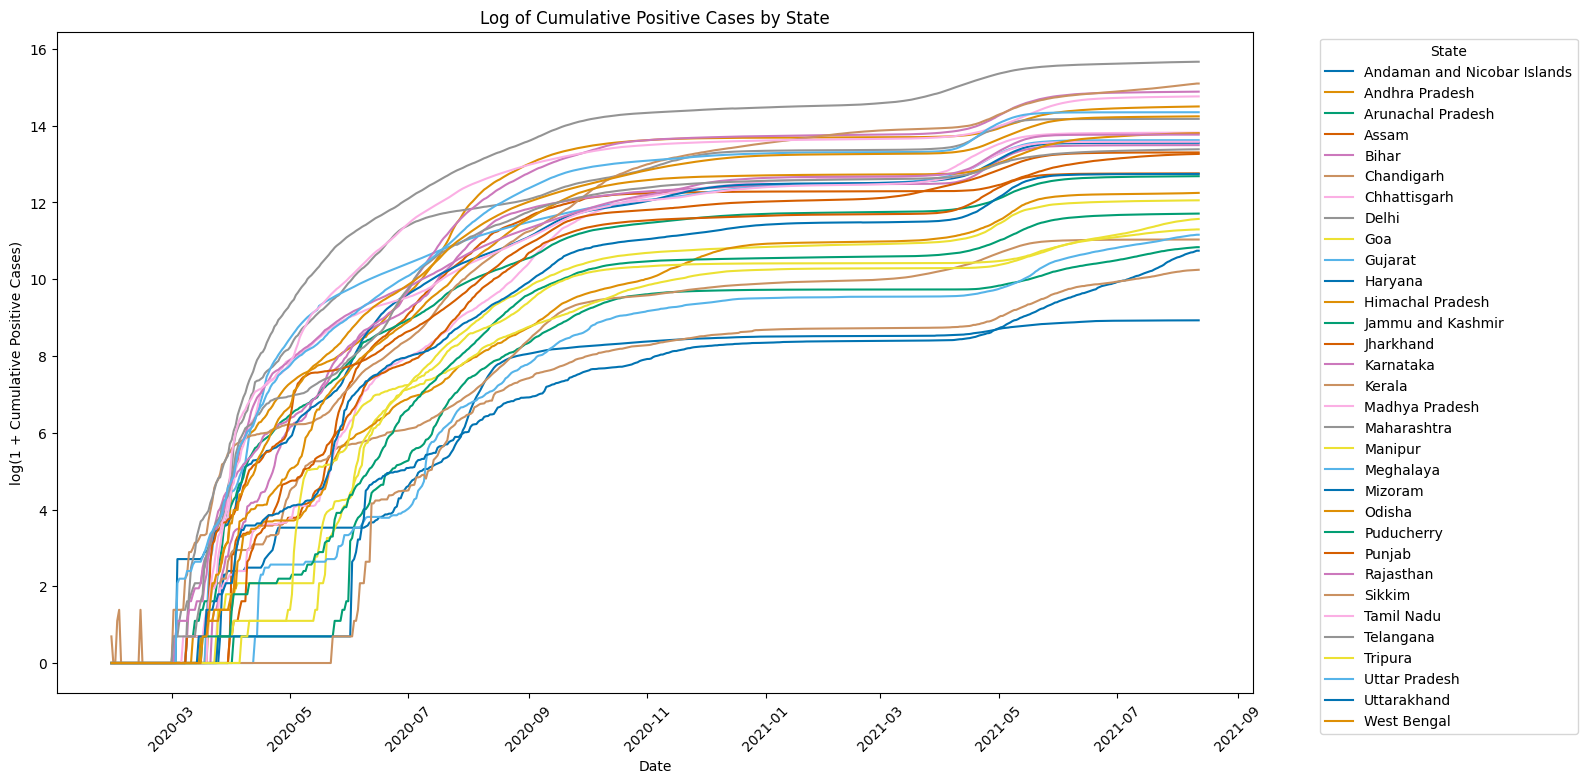

In [9]:
import numpy as np

# plot the cumulative positive cases by state
plt.figure(figsize=(16, 8))
palette = sns.color_palette("colorblind", n_colors=len(df['state'].unique()))

for i, state in enumerate(df['state'].unique()):
    state_data = df[df['state'] == state]
    plt.plot(
        state_data['dates'],
        np.log1p(state_data['cum_positive_cases']),
        label=state,
        color=palette[i]
    )

plt.title('Log of Cumulative Positive Cases by State')
plt.xlabel('Date')
plt.ylabel('log(1 + Cumulative Positive Cases)')
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

A cumulative case series should be monotonically increasing over time. 
However, at the start of the plot, we observe two spikes where the cumulative positive cases decrease, indicating errors in the data. 
Meaning we need to look for cases where the series is not monotonically increasing.

In [7]:
# Count per state how many times the cumulative positive cases are bigger than the day after
cumulative_positive_cases_next_day = (
    df.groupby('state')['cum_positive_cases']
    .apply(lambda x: (x > x.shift(-1)).sum())
    .reset_index(name='count')
)
print("Count of states where cumulative positive cases are greater than the next day:")
print(cumulative_positive_cases_next_day)

Count of states where cumulative positive cases are greater than the next day:
                          state  count
0   Andaman and Nicobar Islands      0
1                Andhra Pradesh      0
2             Arunachal Pradesh      0
3                         Assam      0
4                         Bihar      0
5                    Chandigarh      0
6                  Chhattisgarh      0
7                         Delhi      0
8                           Goa      0
9                       Gujarat      0
10                      Haryana      0
11             Himachal Pradesh      0
12            Jammu and Kashmir      0
13                    Jharkhand      0
14                    Karnataka      0
15                       Kerala      3
16               Madhya Pradesh      0
17                  Maharashtra      1
18                      Manipur      0
19                    Meghalaya      1
20                      Mizoram      0
21                       Odisha      0
22                   Pud

The issue is not widespread—only three data points in Kerala are problematic.  
Upon closer inspection, the problem arose during data merging: missing values were filled with 0 instead of carrying forward the last known value.  
This highlights the importance of thorough EDA for catching such issues early.

# <a name="summary-and-next-steps"></a>Summary and Next Steps

**Summary of actions to take:**
- Remove or adjust problematic columns, including:
    - `"cum_positivity_rate"`
    - `"daily_positive_cases"`
    - `"cum_recovered"`
    - `"daily_cases_per_million"`
    - `"daily_recovered"`
    - `"cum_deceased"`
    - `"daily_deceased"`
    - `"daily_positivity_rate"`
- Correct data points where the cumulative case count decreases.
- Specifically address the identified issues in Kerala's data.
- Remove `"Maharashtra"` from the database

By performing these steps, we ensure the dataset is clean and reliable for downstream modeling and analysis.